In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import pandas as pd
import joblib
import sys
sys.path.append('../lib')
from utils import edf_loader, combiner, annotations_reader, find_breakpoints, find_sections,\
                    section_seiz, find_edf
from transformers import SpectrogramTransformer
from matplotlib import pyplot as plt
from scipy.fft import fft
import time
from scipy.optimize import curve_fit

# Test spectrogram

In [3]:
file1 = '../dataset/edf/train/01_tcp_ar/073/00007313/s001_2010_12_15/00007313_s001_t000.edf'
file2 = '../dataset/edf/train/02_tcp_le/003/00000327/s003_2003_01_13/00000327_s003_t000.edf'
file3 = '../dataset/edf/train/03_tcp_ar_a/009/00000975/s003_2004_10_19/00000975_s003_t000.edf'
file = '../dataset/edf/train/01_tcp_ar/077/00007793/s001_2011_05_27/00007793_s001_t000.edf'

In [4]:
raw = edf_loader(file) # Read edf file
raw.info['montage_type'] = 1

In [8]:
montages, montages_names = combiner(raw)

In [10]:
len(montages)

22

In [6]:
S = SpectrogramTransformer(win_duration=8) # Initialize Transformer
breakpoints = find_breakpoints(file) # Find breakpoints

<ipython-input-13-8c01c3cd02f7>:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(S.t, S.f, Sxx) # Display DB magnitude


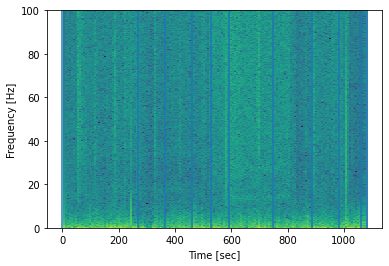

In [13]:
spec_list = S.fit_transform(raw) # Transform data
Sxx = spec_list[0] # Get spectrogram of the first channel

# Display
plt.pcolormesh(S.t, S.f, Sxx) # Display DB magnitude
plt.colorbar
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
for breakpoint in breakpoints:
    plt.axvline(breakpoint)
plt.show()

# Analyze sections

### Create df_sections

In [14]:
files = find_edf('../dataset/edf/train/01_tcp_ar/') # Find edf files

In [15]:
N = 50
files_selection = files[:N] # Select only part of the database

In [16]:
df_sections = joblib.load('df_sections_selection.dump')

### Build model

In [17]:
%%time
df_model = pd.DataFrame([], columns=['Index', 'avg_global', 'avg_bckg', 'avg_seiz'])
df_model['Index'] = np.unique(df_sections.Index)
for i in df_model.Index:
    A = df_sections[df_sections['Index']==i]
    
    # Compute durations
    T_global = 0
    T_seiz = 0
    T_bckg = 0
    for seiz, section in zip(A['seiz'], A['sections']):
        T_global += section[1] - section[0]
        if seiz:
            T_seiz += section[1] - section[0]
        else:
            T_bckg += section[1] - section[0]
            
    # Compute models
    df_model['avg_global'][i] = sum([np.array(spectrum) for spectrum in A['spectrums']])/T_global
    df_model['avg_bckg'][i] = sum([np.array(spectrum) for seiz, spectrum in zip(A['seiz'],A['spectrums']) if not seiz])/T_bckg
    if len(A[A['seiz']]): # For some data no seizure has been observed
        df_model['avg_seiz'][i] = sum([np.array(spectrum) for seiz, spectrum in zip(A['seiz'],A['spectrums']) if seiz])/T_seiz
    else:
        df_model['avg_seiz'][i] = []

CPU times: user 166 ms, sys: 10.8 ms, total: 177 ms
Wall time: 233 ms


<timed exec>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed e

In [19]:
joblib.dump(df_model, 'df_model.dump')

['df_model.dump']

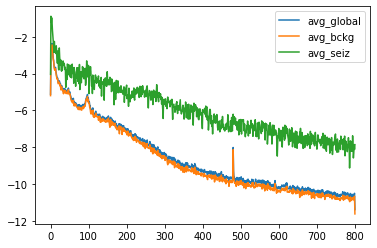

In [18]:
id_file = 9
id_montage = 9
plt.plot(df_model['avg_global'][id_file][id_montage],label='avg_global')
plt.plot(df_model['avg_bckg'][id_file][id_montage], label='avg_bckg')
if len(df_model['avg_seiz'][id_file]):
    plt.plot(df_model['avg_seiz'][id_file][id_montage], label='avg_seiz')
plt.legend()

# Try on an example

In [20]:
from sklearn.metrics.pairwise import euclidean_distances

In [21]:
# folder1 = '../dataset/edf/train/01_tcp_ar/073/00007374/s006_2013_07_03/'
id_file = 0
file1 = files_selection[id_file]
raw = edf_loader(file1)
raw.info['montage_type'] = 1
wd = 8
deltaT = wd-wd*200//8/200

In [22]:
S = SpectrogramTransformer(win_duration=wd)
spectrograms_db_list = S.fit_transform(raw)

## Single channel

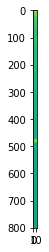

In [24]:
Sxx_db = spectrograms_db_list[0] # Select first channel (montage)
t,f = S.t, S.f
plt.imshow(Sxx_db)

In [25]:
N_freq = Sxx_db.shape[0] # Number of samples along frequency axis
coef = 0.75
spectrum_global = Sxx_db.sum(axis=1)/max(t) # Compute global spectrum
seiz = [sum((Sxx_db[:,col]/deltaT) > spectrum_global) > coef*Sxx_db.shape[0] for col in range(Sxx_db.shape[1])] # Seizure when spectrum is mostly above global spectrum (more than coef% of the time)

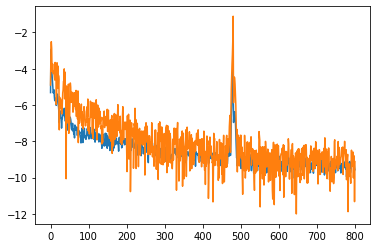

In [26]:
col = 10
plt.plot(spectrum_global)
plt.plot(Sxx_db[:,col]/deltaT)

In [27]:
sum(seiz)

12

## Combine montages (count for each section on how many montages a seizure has been predicted)

In [29]:
%%time
coef = 0.75

all_montages_new_annotations = []
for id_montage, Sxx_db in enumerate(spectrograms_db_list):
    spectrum_global = Sxx_db.sum(axis=1)/max(t) # Compute global spectrum for each montage
    # Check which sections are considered as seizures
    all_montages_new_annotations.append([sum(sample > spectrum_global) > coef*len(sample)
                                          for sample in Sxx_db.T/deltaT])

# Combine annotations : if there is a seizure event on one montage, then we consider a generalized seizure
combined_annotation = np.array(all_montages_new_annotations).sum(axis=0)

CPU times: user 938 ms, sys: 0 ns, total: 938 ms
Wall time: 938 ms


In [30]:
sum(combined_annotation.astype(bool))

12

In [31]:
list(enumerate(combined_annotation))

[(0, 20),
 (1, 0),
 (2, 0),
 (3, 22),
 (4, 20),
 (5, 18),
 (6, 14),
 (7, 15),
 (8, 7),
 (9, 10),
 (10, 7),
 (11, 11),
 (12, 13),
 (13, 7)]